In [2]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
#plt.style.use('ggplot')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [ ]:
# Data imports
my_name = 'Exp6'
cohort = 'ADNI2'
clinical_scale = 'ADAS13'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)
atlas = 'AAL'

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
HC_L_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,my_name)
HC_R_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,my_name)
CT_data_path = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)
CT_unique_ROIs_path = baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas)
sub_CS_data_path = baseline_dir + 'CS/{}_BL_PTID_{}_dict.pkl'.format(cohort,clinical_scale)
sub_DX_data_path = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)
sub_age_data_path = baseline_dir + 'CS/{}_age.pkl'.format(cohort)
sub_sex_data_path = baseline_dir + 'CS/{}_sex.pkl'.format(cohort)

In [ ]:
#Fused labels and volumes
sub_HC_L_dict = pickle.load( open(HC_L_data_path, "rb" ) )
sub_HC_R_dict = pickle.load( open(HC_R_data_path, "rb" ) )

HC_L_total_vol_dict = {}
HC_R_total_vol_dict = {}

HC_common_keys = set(sub_HC_L_dict.keys()) & set(sub_HC_R_dict.keys())
print 'Common HC keys: {}'.format(len(HC_common_keys))
for key in HC_common_keys:
    fused_vol = stats.mode(sub_HC_L_dict[key],axis=0)[0] #Left HC
    HC_L_total_vol_dict[key] = np.sum(fused_vol)
    fused_vol = stats.mode(sub_HC_R_dict[key],axis=0)[0] #Right HC
    HC_R_total_vol_dict[key] = np.sum(fused_vol)
    
#Mean CT values for AAL
sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
unique_ROIs = pickle.load( open(CT_unique_ROIs_path, "rb" ) )
#unique_ROIs = sub_CT_dict['137_S_0459'][0].keys()
CT_mean_dict = {}
for key in sub_CT_dict.keys():
    CT_roi_dict = sub_CT_dict[key][0]
    mean_CT_list = []
    for roi in unique_ROIs:
        #ignore roi list (mainly the background ones...)
        if not roi in [0]:
            mean_CT_list.append(np.mean(CT_roi_dict[roi]))
                
    CT_mean_dict[key] = mean_CT_list
    
print 'HC_L_keys: {}, HC_R_keys: {}, CT_keys: {}'.format(len(HC_L_total_vol_dict), len(HC_R_total_vol_dict), len(CT_mean_dict))

In [ ]:
#print stats.mode(sub_HC_L_dict[key],axis=0)[0].shape
#print stats.mode(sub_HC_R_dict[key],axis=0)[0].shape
#sub_age_dict = pickle.load(open(sub_age_data_path, "rb"))
#sub_sex_dict = pickle.load(open(sub_sex_data_path, "rb"))

sub_CS_dict = pickle.load( open(sub_CS_data_path, "rb" ) )
sub_CS_dict_clean = filter(lambda k: not isnan(sub_CS_dict[k]), sub_CS_dict) #remove NaNs
sub_CS_dict_clean = {k: sub_CS_dict[k] for k in sub_CS_dict if not isnan(sub_CS_dict[k])}

print cohort, clinical_scale
scores = sub_CS_dict_clean.values()
print np.mean(scores), np.std(scores),  np.min(scores), np.max(scores)

In [ ]:
#Dump the unique ordered list of CT ROIs that is consistent across ADNI1 and 2. 
sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
unique_ROIs = sub_CT_dict['137_S_0459'][0].keys()
print len(unique_ROIs)
pickleIt(unique_ROIs,baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas))

In [ ]:
use_demographics = False
# ADAS score dict
sub_CS_dict = pickle.load( open(sub_CS_data_path, "rb" ) )
sub_CS_dict_clean = filter(lambda k: not isnan(sub_CS_dict[k]), sub_CS_dict) #remove NaNs
sub_CS_dict_clean = {k: sub_CS_dict[k] for k in sub_CS_dict if not isnan(sub_CS_dict[k])}

#Dx score dict (for stratified k-fold)
sub_DX_dict = pickle.load( open(sub_DX_data_path, "rb" ) )
#sub_DX_dict_clean = filter(lambda k: not isnan(sub_DX_dict[k]), sub_DX_dict) #remove NaNs
#sub_DX_dict_clean = {k: sub_DX_dict[k] for k in sub_DX_dict if not isnan(sub_DX_dict[k])}

#Demographics
sub_age_dict = pickle.load(open(sub_age_data_path, "rb"))
sub_sex_dict = pickle.load(open(sub_sex_data_path, "rb"))
    
common_keys = list(set(HC_L_total_vol_dict.keys()) & set(HC_R_total_vol_dict.keys()) 
                   & set(CT_mean_dict.keys()) & set(sub_CS_dict_clean.keys()))
print '# of common keys across modalities: {}'.format(len(common_keys))
X = []
y = []
y_dx = [] #Used for creating balanced k-folds
for key in common_keys:
    if use_demographics: #Age does come up as important feature from RF runs :-)
        #print "using age and sex variables"
        X.append(np.array([HC_L_total_vol_dict[key]] + [HC_R_total_vol_dict[key]] + CT_mean_dict[key] + 
                         [sub_age_dict[key]] + [sub_sex_dict[key]]))
    else:
        X.append(np.array([HC_L_total_vol_dict[key]] + [HC_R_total_vol_dict[key]] + CT_mean_dict[key]))
        
    y.append(sub_CS_dict_clean[key])
    if key in sub_DX_dict:
        if sub_DX_dict[key] in ['EMCI','LMCI']:
            y_dx.append('MCI')
        elif sub_DX_dict[key] in ['CN','SMC']:   
            y_dx.append('CN')
        elif sub_DX_dict[key] in ['AD']:  
            y_dx.append('AD')
        else:
            print "Unknown Dx"
    else:
        print "No Dx found for {}".format(key)
        y_dx.append('CN') #Two subjects without Dx 
    
X = np.array(X)
y = np.array(y)
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)

In [9]:
# Combine ADNI1 and ADNI2 cohorts 
def concatCohorts(exp_setup_path_1,exp_setup_path_2):
    exp_setup = pickle.load( open(exp_setup_path_1, "rb" ) )
    X1 = exp_setup['X']
    y1 = exp_setup['y']
    y1_dx = exp_setup['y_dx']
    exp2_common_subs = exp_setup['common_subs']
    exp_setup = pickle.load( open(exp_setup_path_2, "rb" ) )
    X2 = exp_setup['X']
    y2 = exp_setup['y']
    y2_dx = exp_setup['y_dx']
    exp1_common_subs = exp_setup['common_subs']
    
    #concat
    X = np.vstack((X1,X2))
    y = np.concatenate((y1,y2))
    y_dx = np.concatenate((y1_dx,y2_dx))
    common_subs = exp1_common_subs + exp2_common_subs

    return {'X':X, 'y':y, 'y_dx':y_dx, 'common_subs':common_subs}

def concatDictionaries(modality_path_dict_1,modality_path_dict_2):    #Not tested yet.. 
    #input: {'L_HC':'path/to/dict',...,'CS':'path/to/dict' }
    comb_data_dict = {}
    for modality in modality_path_dict_1.keys():
        adni1_data = pickle.load( open(modality_path_dict_1[modality], "rb" ) )
        adni2_data = pickle.load( open(modality_path_dict_2[modality], "rb" ) )
        #check for common entries --> which shouldn't exist
        common_keys = list(set(adni1_data.keys()) & set(adni2_data.keys()))
        if len(common_keys) > 0:
            print '{} common_keys found across cohorts for modality: {}'.format(len(common_keys),modality)
        else:
            adni_1_2_data = adni1_data.copy()
            adni_1_2_data.update(adni2_data)            
            comb_data_dict[modality] = adni_1_2_data
            print '{} data combined with {} total subjects'.format(modality, len(adni_1_2_data))
        
    return comb_data_dict

In [13]:
# either 'exp': combines experimental data for adni1 and 2 --> used for baseline models
# or 'dict' for NN models. Combine HC,CT,CS
# kf from exp-concatination is still used for NN model CV
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

concat_type = 'exp' 
exp_name = 'Exp6'
Clinical_Scale = 'MMSE'
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/'
save_combined_KFold_setup = True
if concat_type == 'exp':
    print 'Combining exp-setups'
    for mc in np.arange(1,11,1):
        exp_setup_path_adni1 = baseline_dir + 'CV_{}_ADNI1_{}_MC_{}.pkl'.format(exp_name, Clinical_Scale, mc)
        exp_setup_path_adni2 = baseline_dir + 'CV_{}_ADNI2_{}_MC_{}.pkl'.format(exp_name, Clinical_Scale, mc)

        comb_data = concatCohorts(exp_setup_path_adni1,exp_setup_path_adni2)
        X = comb_data['X']
        y = comb_data['y']
        y_dx = comb_data['y_dx']
        common_keys = comb_data['common_subs']
        print X.shape, y.shape, len(common_keys)
        exp_name_out = '{}_ADNI1and2_{}_MC_{}'.format(exp_name, Clinical_Scale, mc)
        print exp_name_out

        if save_combined_KFold_setup:
            le = preprocessing.LabelEncoder()
            le.fit(y_dx)
            y_dx_int = le.transform(y_dx) 
            kf = StratifiedKFold(y_dx_int, n_folds=10, shuffle=True, random_state=mc)
            for train_index, test_index in kf:    
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx_int[test_index]==0),
                                                                 np.sum(y_dx_int[test_index]==1),
                                                                 np.sum(y_dx_int[test_index]==2)))
                print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))

                save_path = baseline_dir + 'CV_{}.pkl'.format(exp_name_out)    
                print 'Saving exp_setup to: {}'.format(save_path)
                exp_setup = {'X': X, 'y': y, 'y_dx': y_dx, 'kf':kf,'common_subs':common_keys,'exp_name':exp_name_out}    
                pickleIt(exp_setup, save_path) 
    
elif concat_type == 'dict':
    print 'Combining dictionaries' 
    cohort = 'ADNI1'
    modality_path_dict_1 = {}
    modality_path_dict_2 = {}
    modality_path_dict_1['HC_L'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,exp_name)
    modality_path_dict_1['HC_R'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,exp_name)
    modality_path_dict_1['CT'] = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)    
    modality_path_dict_1['CS'] = baseline_dir + 'CS/{}_BL_PTID_ADAS13_dict.pkl'.format(cohort)
    modality_path_dict_1['DX'] = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)
    cohort = 'ADNI2' 
    modality_path_dict_2['HC_L'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,exp_name)
    modality_path_dict_2['HC_R'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,exp_name)
    modality_path_dict_2['CT'] = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)    
    modality_path_dict_2['CS'] = baseline_dir + 'CS/{}_BL_PTID_ADAS13_dict.pkl'.format(cohort)
    modality_path_dict_2['DX'] = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)
    
    comb_data = concatDictionaries(modality_path_dict_1,modality_path_dict_2)
    
    for key in comb_data.keys():
        print '{} : {}'.format(key, len(comb_data[key]))
else:
    print 'Wrong concat_type'
    

Combining exp-setups
(1369, 80) (1369,) 1369
Exp6_ADNI1and2_MMSE_MC_1
DX distribution (AD,CN,LMCI): (28, 46, 65)
y_train_mean: 27.2008130081, y_test_mean: 27.0431654676
Saving exp_setup to: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/CV_Exp6_ADNI1and2_MMSE_MC_1.pkl
DX distribution (AD,CN,LMCI): (28, 46, 65)
y_train_mean: 27.1861788618, y_test_mean: 27.1726618705
Saving exp_setup to: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/CV_Exp6_ADNI1and2_MMSE_MC_1.pkl
DX distribution (AD,CN,LMCI): (28, 46, 64)
y_train_mean: 27.1900893582, y_test_mean: 27.1376811594
Saving exp_setup to: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/CV_Exp6_ADNI1and2_MMSE_MC_1.pkl
DX distribution (AD,CN,LMCI): (27, 46, 64)
y_train_mean: 27.1761363636, y_test_mean: 27.2627737226
Saving exp_setup to: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/CV_Exp6_ADNI1and2_MMSE_MC_1.pkl
DX distribution (AD,CN,LMCI): (27, 45, 64)
y_t

In [ ]:
# Save concatinated dictionaries
cohort = 'ADNI1and2'
modality_path_dict_comb = {}
modality_path_dict_comb['HC_L'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,exp_name)
modality_path_dict_comb['HC_R'] = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,exp_name)
modality_path_dict_comb['CT'] = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)    
modality_path_dict_comb['CS'] = baseline_dir + 'CS/{}_BL_PTID_ADAS13_dict.pkl'.format(cohort)
modality_path_dict_comb['DX'] = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)

for key in comb_data.keys():
    pickleIt(comb_data[key],modality_path_dict_comb[key])

In [ ]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

#Encode Dx labels to integers map: {AD:0,CN:1,LMCI:2}
le = preprocessing.LabelEncoder()
le.fit(y_dx)
y_dx_int = le.transform(y_dx) 

KF_type = baseline_dir + 'exp_data/CV_Exp6_ADNI1and2_ADAS13.pkl'  #'path/to/previous/setup' or 'stratified' or 'none'
if KF_type == 'none':
    print 'KFold'
    kf = KFold(len(y), n_folds=10)
elif KF_type == 'stratified': 
    print 'Stratified KFold'
    kf = StratifiedKFold(y_dx_int, n_folds=10)
else:
    print 'Loading previously saved KF from: {}'.format(KF_type)
    old_exp_setup = pickle.load( open(KF_type, "rb" ) )
    kf = old_exp_setup['kf']
    
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx_int[test_index]==0),np.sum(y_dx_int[test_index]==1),
                                              np.sum(y_dx_int[test_index]==2)))
    print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))
    
save_experimental_setup = True #Saves X, y, and KF
save_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_{}.pkl'.format(exp_name)    
print 'Saving exp_setup to: {}'.format(save_path)
if save_experimental_setup:    
    exp_setup = {'X': X, 'y': y, 'y_dx': y_dx, 'kf':kf,'common_subs':common_keys,'exp_name':exp_name}    
    pickleIt(exp_setup, save_path)        

In [ ]:
# QC plots
n_feat = X.shape[1]
print X.shape

feat_corr  = []
for col in np.arange(n_feat):
    feat_corr.append(stats.pearsonr(X[:,col],y)[0])

print 'L_HC corr: {}, R_HC_corr: {}'.format(feat_corr[0],feat_corr[1]) 
print 'HC Correlation in each fold'
fid = 1
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_L_HC_vol_mean = np.mean(X_train[:,0])
    train_L_HC_vol_std = np.std(X_train[:,0])
    train_R_HC_vol_mean = np.mean(X_train[:,1])
    train_R_HC_vol_std = np.std(X_train[:,1])
    
    test_L_HC_vol_mean = np.mean(X_test[:,0])
    test_L_HC_vol_std = np.std(X_test[:,0])
    test_R_HC_vol_mean = np.mean(X_test[:,1])
    test_R_HC_vol_std = np.std(X_test[:,1])
    
    train_L_HC_corr = stats.pearsonr(X_train[:,0],y_train)[0]
    train_R_HC_corr = stats.pearsonr(X_train[:,1],y_train)[0]
    test_L_HC_corr = stats.pearsonr(X_test[:,0],y_test)[0]
    test_R_HC_corr = stats.pearsonr(X_test[:,1],y_test)[0]
    print fid
    fid+=1
    print 'test L_HC vol, std, corr: {}, {}, {}'.format(test_L_HC_vol_mean,test_L_HC_vol_std,test_L_HC_corr)
    print 'test R_HC vol, std, corr: {}, {}, {}'.format(test_R_HC_vol_mean,test_R_HC_vol_std,test_R_HC_corr)
    print 'train L_HC vol, std, corr: {}, {}, {}'.format(train_L_HC_vol_mean,train_L_HC_vol_std,train_L_HC_corr)
    print 'train R_HC vol, std, corr: {}, {}, {}'.format(train_R_HC_vol_mean,train_R_HC_vol_std,train_R_HC_corr)
    

alpha = 0.5
plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2,2,1)
plt.title('HC_L total volume')
plt.hist(X[y_dx_int==0,0],bins=100,alpha=alpha,label='AD: {}'.format(np.mean(X[y_dx_int==0,0])))
plt.hist(X[y_dx_int==1,0],bins=100,alpha=alpha,label='CN: {}'.format(np.mean(X[y_dx_int==1,0])))
plt.hist(X[y_dx_int==2,0],bins=100,alpha=alpha,label='MCI: {}'.format(np.mean(X[y_dx_int==2,0])))
plt.legend()
plt.subplot(2,2,2)
plt.title('HC_R total volume')
plt.hist(X[y_dx_int==0,1],bins=100,alpha=alpha,label='AD: {}'.format(np.mean(X[y_dx_int==0,1])))
plt.hist(X[y_dx_int==1,1],bins=100,alpha=alpha,label='CN: {}'.format(np.mean(X[y_dx_int==1,1])))
plt.hist(X[y_dx_int==2,1],bins=100,alpha=alpha,label='MCI: {}'.format(np.mean(X[y_dx_int==2,1])))
plt.legend()
plt.subplot(2,2,3)
plt.title('CT mean per ROI')
plt.bar(np.arange(n_feat-2),np.mean(X[:,2:],axis=0))
plt.subplot(2,2,4)
plt.title('Correlation with CS for each feature')
plt.bar(np.arange(n_feat),feat_corr)

In [ ]:
adni1_covar_df =  pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/CS/adni1_covar.pkl', "rb" ) )
adni2_covar_df =  pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/CS/adni2_covar.pkl', "rb" ) )

print 'ADNI1'
print adni1_covar_df.describe()
print 'ADNI2'
print adni2_covar_df.describe()
                                                 


In [ ]:
#Volume significance testing across ADNI1 and 2
import statsmodels.formula.api as smf
#'AGE','PTGENDER','WholeBrain'
cols=('ID', 'cohort', 'Age', 'Sex', 'TBV', 'HC_L', 'HC_R')

meth_df = pd.DataFrame(columns=cols)
adni1_covar_df =  pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/CS/adni1_covar.pkl', "rb" ) )
adni2_covar_df =  pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/CS/adni2_covar.pkl', "rb" ) )

cohort = 'adni1'
for img_idx in adni1_HC_L_total_vol_dict.keys():
    row = pd.Series([img_idx, cohort, np.array(adni1_covar_df[(adni1_covar_df.PTID ==img_idx)]['AGE'])[0], 
                 np.array(adni1_covar_df[(adni1_covar_df.PTID ==img_idx)]['PTGENDER'])[0], 
                 np.array(adni1_covar_df[(adni1_covar_df.PTID ==img_idx)]['WholeBrain'])[0], 
                 adni1_HC_L_total_vol_dict[img_idx], adni1_HC_R_total_vol_dict[img_idx]], index=cols)
        
    #add row to the table
    meth_df.loc[len(meth_df)] = row
    
cohort = 'adni2'
for img_idx in adni2_HC_L_total_vol_dict.keys():
    row = pd.Series([img_idx, cohort, np.array(adni2_covar_df[(adni2_covar_df.PTID ==img_idx)]['AGE'])[0], 
                 np.array(adni2_covar_df[(adni2_covar_df.PTID ==img_idx)]['PTGENDER'])[0], 
                 np.array(adni2_covar_df[(adni2_covar_df.PTID ==img_idx)]['WholeBrain'])[0], 
                 adni2_HC_L_total_vol_dict[img_idx], adni2_HC_R_total_vol_dict[img_idx]], index=cols)
        
    #add row to the table
    meth_df.loc[len(meth_df)] = row
        
#meth_df
est = smf.ols(formula='HC_R ~ Sex + Age + TBV + C(cohort, Treatment(reference="adni1"))', data=meth_df).fit()
print 't_vals:'
print est.tvalues
print 'p_vals:'
print est.pvalues


In [ ]:
# Load save experimental setup
cohort = 'ADNI2'
exp_name = 'Exp6'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_{}_{}_ADAS13.pkl'.format(exp_name,cohort)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X = exp_setup['X']
y = exp_setup['y']
# y_dx = exp_setup['y_dx']
# le = preprocessing.LabelEncoder()
# le.fit(y_dx)
# y_dx_int = le.transform(y_dx) 

print cohort
# print 'Left HC'
# print 'AD: {}'.format(int(np.mean(X[y_dx_int==0,0])))
# print 'MCI: {}'.format(int(np.mean(X[y_dx_int==2,0])))
# print 'CN: {}'.format(int(np.mean(X[y_dx_int==1,0])))
# print 'Right HC'
# print 'AD: {}'.format(int(np.mean(X[y_dx_int==0,1])))
# print 'MCI: {}'.format(int(np.mean(X[y_dx_int==2,1])))
# print 'CN: {}'.format(int(np.mean(X[y_dx_int==1,1])))
# print  'CT'
# print 'AD: {}'.format((np.mean(X[y_dx_int==0,2:])))
# print 'MCI: {}'.format((np.mean(X[y_dx_int==2,2:])))
# print 'CN: {}'.format((np.mean(X[y_dx_int==1,2:])))

#ADNI1: CT
#AD: 2.89622991643
#MCI: 2.98721598902
#CN: 3.06806548109
#ADNI2: CT
#AD: 2.79175707773
#MCI: 2.92246056401
#CN: 2.9658935139

kf = exp_setup['kf']
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print y_test
    
#print y_test

In [14]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

In [15]:
#Pick model with its configs/hyper-paramsd
def getModel(model_choice):     
    if model_choice == 'LR_L1':
        model_clf = Lasso()
        hyper_params = {'alpha':[0.1, 0.05, 0.01]} 
        scale_data = True #Scales HC and CT features    
        feat_imp = False   
        
    elif model_choice == 'SVR':
        model_clf = SVR()
        hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
        scale_data = True #Scales HC and CT features        
        feat_imp = False

    elif model_choice == 'RFR':
        model_clf = RandomForestRegressor(n_jobs=4)
        hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}    
        scale_data = False    
        feat_imp = False   
        
    else:
        print "Unknown model choice"


    return {'model_clf':model_clf,'hyper_params':hyper_params,'scale_data':scale_data,'feat_imp':feat_imp}

In [69]:
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
# Load save experimental setup
cohort = 'ADNI2'
exp_name = 'Exp6'
Clinical_Scale = 'ADAS13'
save_experimental_setup = True #Saves X, y, and KF

exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_{}_{}_{}.pkl'.format(exp_name,cohort,Clinical_Scale)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X = exp_setup['X']
y = exp_setup['y']
y_dx = exp_setup['y_dx']
kf = exp_setup['kf']
exp_name_long = exp_setup['exp_name']
common_keys = exp_setup['common_subs']

print 'exp_name:{}'.format(exp_name)
#Encode Dx labels to integers map: {AD:0,CN:1,LMCI:2}
le = preprocessing.LabelEncoder()
le.fit(y_dx)
y_dx_int = le.transform(y_dx) 

MC_runs = 10

for m in np.arange(MC_runs):
    kf = StratifiedKFold(y_dx_int, n_folds=10, shuffle=True, random_state=m)

    for train_index, test_index in kf:    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx_int[test_index]==0),np.sum(y_dx_int[test_index]==1),
                                                  np.sum(y_dx_int[test_index]==2)))
        print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))


    save_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/CV_{}_MC_{}.pkl'.format(exp_name_long,m+1)    
    print 'Saving exp_setup to: {}'.format(save_path)
    if save_experimental_setup:    
        exp_setup = {'X': X, 'y': y, 'y_dx': y_dx, 'kf':kf,'common_subs':common_keys,'exp_name':exp_name_long}    
        pickleIt(exp_setup, save_path)  

exp_name:Exp6
DX distribution (AD,CN,LMCI): (13, 26, 32)
y_train_mean: 15.6801292407, y_test_mean: 16.8873239437
DX distribution (AD,CN,LMCI): (13, 26, 31)
y_train_mean: 15.785483871, y_test_mean: 15.9714285714
DX distribution (AD,CN,LMCI): (13, 26, 31)
y_train_mean: 15.7, y_test_mean: 16.7285714286
DX distribution (AD,CN,LMCI): (12, 26, 31)
y_train_mean: 15.7729468599, y_test_mean: 16.0869565217
DX distribution (AD,CN,LMCI): (12, 26, 31)
y_train_mean: 15.9694041868, y_test_mean: 14.3188405797
DX distribution (AD,CN,LMCI): (12, 26, 31)
y_train_mean: 15.9162640902, y_test_mean: 14.7971014493
DX distribution (AD,CN,LMCI): (12, 25, 31)
y_train_mean: 15.7057877814, y_test_mean: 16.7058823529
DX distribution (AD,CN,LMCI): (12, 25, 31)
y_train_mean: 15.7829581994, y_test_mean: 16.0
DX distribution (AD,CN,LMCI): (12, 25, 31)
y_train_mean: 15.8327974277, y_test_mean: 15.5441176471
DX distribution (AD,CN,LMCI): (12, 25, 31)
y_train_mean: 15.8971061093, y_test_mean: 14.9558823529
Saving exp_setu

In [16]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load save experimental setup
cohort = 'ADNI1and2'
exp_name = 'Exp6'
Clinical_Scale = 'MMSE'
MC_runs = 10
save_CV_perf = True    
# Parallization configs for ipython notebook cluster    
rc = ipp.Client()
dview = rc[:]
dview.push(dict(computeOuterFold = computeOuterFold))
dview.push(dict(innerCVLoop = innerCVLoop))

#----------------------------------
# Iterate through MC folds --> Modalitiies --> --> Model Choices --> k-folds (total 10x3x3x10 runs)
idx = 1
df_perf_dict = {}

#Some paths to store models and performance stats
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/'
CV_model_dir = baseline_dir + 'output/'
save_model = False #do you really want to save all classifiers per each fold? (default false) 

modalities = ['HC','CT','HC_CT']
model_list = ['LR_L1','SVR','RFR']

for m in np.arange(1,MC_runs+1,1):
    exp_setup_path = baseline_dir + 'CV_{}_{}_{}_MC_{}.pkl'.format(exp_name,cohort,Clinical_Scale,m)
    exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

    X_raw = exp_setup['X']    
    
    for modality in modalities:
        if modality == 'HC_CT':
            X_modality = X_raw
        elif modality == 'HC':
            X_modality = X_raw[:,:2]
        elif modality == 'CT':
            X_modality = X_raw[:,2:]
        else:
            print "Wrong modality selected..."       

        y = exp_setup['y']
        kf = exp_setup['kf']
        exp_name_long = exp_setup['exp_name']

        for model_choice in model_list:
            model_def = getModel(model_choice)
            model_clf = model_def['model_clf']
            hyper_params = model_def['hyper_params']
            scale_data = model_def['scale_data']    
            feat_imp = model_def['feat_imp']
            
            save_model_path = CV_model_dir + exp_name_long + '_' + model_choice
            
            if scale_data:
                X = preprocessing.scale(X_modality)
            else:
                X = X_modality            

            # Create list of all the fold-subsets (needed for parallelization)
            X_train = []
            X_valid = []
            y_train = []
            y_valid = []    
            for train, valid in kf:        
                X_train.append(X[train])
                X_valid.append(X[valid])
                y_train.append(y[train])
                y_valid.append(y[valid])

            CV_r_train=[] #pearson r score for each outer fold on train set
            CV_r_valid=[] #pearson r score for each outer fold on validation set

            CV_R2_train=[] #R2 score for each outer fold on train set
            CV_R2_valid=[] #R2 score for each outer fold on validation set

            CV_MSE_train=[] #MSE for each outer fold on train set
            CV_MSE_valid=[] #MSE for each outer fold on validation set
            
            CV_RMSE_train=[] #MSE for each outer fold on train set
            CV_RMSE_valid=[] #MSE for each outer fold on validation set

            predicted_CV_scores = []
            actual_CV_scores = []

            #Parallelize k-folds
            mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=True, 
                          save_model=save_model, save_model_path=save_model_path)
            parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    

            hp_dict = collections.defaultdict(list)
            for p, pr in enumerate(parallel_result):
                CV_r_train.append(pr['r_train'])
                CV_r_valid.append(pr['r_valid'])
                CV_R2_train.append(pr['R2_train'])
                CV_R2_valid.append(pr['R2_valid'])
                CV_MSE_train.append(pr['MSE_train'])
                CV_MSE_valid.append(pr['MSE_valid'])
                CV_RMSE_train.append(pr['RMSE_train'])
                CV_RMSE_valid.append(pr['RMSE_valid'])
                predicted_CV_scores.append(pr['predicted_fold_score'])
                actual_CV_scores.append(pr['actual_fold_scores'])
                
                df_perf_dict[idx] = {'MC':m,'modality':modality,'model_choice':model_choice,'KF':p+1,
                                     'CV_R2':pr['R2_valid'],'CV_MSE':pr['MSE_valid'],'CV_RMSE':pr['RMSE_valid'],'CV_r':pr['r_valid']}
                
                idx+=1
                for hp in hyper_params:
                    hp_dict[hp].append(pr['hp_dict'][hp])
    
            #Find out most frequent hyper-params during cross-val    
            hp_mode = {}
            for hp in hyper_params:
                hp_mode[hp] = mode(hp_dict[hp])[0][0]

            print 'most frequent hp:' + str(hp_mode)
        
            print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
            #print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
            #print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))
            print 'CV RMSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_RMSE_valid),np.median(CV_RMSE_valid),stats.sem(CV_RMSE_valid))
            
            
            if save_CV_perf:
                ts = time.time()
                st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
                save_model_filename = '{}_{}_MC_{}_{}.pkl'.format(save_model_path,modality,m,st)
                #old way of saving results
                classifier_model_and_stats = {'best_clf_hyp':hp_mode,'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_RMSE':CV_RMSE_valid, 
                                              'CV_r': CV_r_valid,'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
                pickleIt(classifier_model_and_stats,save_model_filename)                                    
                
            
#Save df style dictionaly for seaborn plots
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}.pkl'.format(exp_name, cohort, Clinical_Scale)                
pickleIt(df_perf_dict,df_perf_dict_path)
print 'saving results at: {}'.format(save_model_filename)

most frequent hp:{'alpha': array([ 0.1])}
CV r (mean, median, std_err): 0.15,0.17,0.03
CV RMSE (mean, median, std_err): 2.64,2.62, 0.04
most frequent hp:{'kernel': array(['rbf'], 
      dtype='|S3'), 'C': array([1])}
CV r (mean, median, std_err): 0.22,0.20,0.02
CV RMSE (mean, median, std_err): 2.70,2.71, 0.04
most frequent hp:{'n_estimators': array([200]), 'min_samples_split': array([8])}
CV r (mean, median, std_err): 0.16,0.16,0.02
CV RMSE (mean, median, std_err): 2.75,2.72, 0.04
most frequent hp:{'alpha': array([ 0.05])}
CV r (mean, median, std_err): 0.50,0.47,0.03
CV RMSE (mean, median, std_err): 2.31,2.31, 0.06
most frequent hp:{'kernel': array(['rbf'], 
      dtype='|S3'), 'C': array([1])}
CV r (mean, median, std_err): 0.52,0.50,0.02
CV RMSE (mean, median, std_err): 2.31,2.29, 0.05
most frequent hp:{'n_estimators': array([200]), 'min_samples_split': array([2])}
CV r (mean, median, std_err): 0.50,0.47,0.03
CV RMSE (mean, median, std_err): 2.30,2.30, 0.05
most frequent hp:{'alpha': 

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [78]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
perf = pickle.load( open(baseline_dir + 'Exp6_ADNI1_ADAS13_SVR_HC_MC_1_2016-10-09-15-20-09.pkl') )
print perf['actual_CV_scores'][6]

[ 18.    21.67  11.67  31.     8.67   5.    20.     9.67   6.    29.    31.33
  40.67  33.33   9.33  15.33  47.67  12.33  25.67   6.67  11.67   4.33  11.
   9.67  28.33  17.33  17.    27.33  15.67  11.    29.67  18.    34.33  12.
  10.33  17.33  14.33  10.33  19.33  26.33  26.67  32.33  20.33  19.    23.
  13.    30.    17.67   8.    21.    12.33  12.     8.     5.67  23.     9.67
  15.    14.     5.    14.67  23.33  23.33  29.33  11.33  28.33  12.    14.33]


In [152]:
import seaborn as sns

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
p=0
for cohort in ['ADNI1']:
    for clinical_scale in ['ADAS13','MMSE']:        
        print cohort, clinical_scale
        df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp6_{}_{}.pkl'.format(cohort,clinical_scale), 'rb') )
        df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
        df['CV_r_val']= (zip(*df['CV_r'].values)[0])
        df['CV_r_pval']= (zip(*df['CV_r'].values)[1])
        df['cohort_CS']=np.tile('{}_{}'.format(cohort,clinical_scale),len(df_perf_dict))
        
        for modality in ['HC','CT','HC_CT']:
            for model_choice in ['LR_L1','SVR','RFR']:                
                stat_values = df[(df.modality==modality) & (df.model_choice==model_choice)][['CV_r_val','CV_RMSE']].values
                print '{},{},  {:3.2f},{:3.2f},  {:3.2f},{:3.2f}'.format(modality, model_choice, np.mean(stat_values,axis=0)[0],np.std(stat_values,axis=0)[0],
                                                         np.mean(stat_values,axis=0)[1],np.std(stat_values,axis=0)[1])
                
        if p==0:
            df_concat = df
        else:        
            df_concat = df_concat.append(df)
            
        p+=1

#Append APANN dictionary to df
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/output/'
for cohort in ['ADNI1']:
    for clinical_scale in ['ADAS13','MMSE']:
        for modality in ['HC','CT','HC_CT']:
            df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp6_MC_{}_{}_{}_tuned.pkl'.format(cohort,modality, clinical_scale), 'rb') )
            df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
            df['CV_r_val']=df['CV_r']
            df['CV_r_pval']=df['CV_r']*0
            df['cohort_CS']=np.tile('{}_{}'.format(cohort,clinical_scale),len(df_perf_dict))
            df_concat = df_concat.append(df)
       

ADNI1 ADAS13
HC,LR_L1,  0.22,0.11,  8.72,0.81
HC,SVR,  0.23,0.11,  8.70,0.85
HC,RFR,  0.15,0.10,  9.27,0.80
CT,LR_L1,  0.56,0.08,  7.44,0.72
CT,SVR,  0.52,0.08,  7.68,0.76
CT,RFR,  0.54,0.08,  7.55,0.76
HC_CT,LR_L1,  0.56,0.08,  7.42,0.74
HC_CT,SVR,  0.53,0.08,  7.62,0.78
HC_CT,RFR,  0.54,0.08,  7.51,0.77
ADNI1 MMSE
HC,LR_L1,  0.23,0.12,  2.54,0.18
HC,SVR,  0.25,0.12,  2.59,0.19
HC,RFR,  0.22,0.11,  2.63,0.21
CT,LR_L1,  0.49,0.08,  2.28,0.17
CT,SVR,  0.48,0.07,  2.31,0.16
CT,RFR,  0.48,0.08,  2.30,0.17
HC_CT,LR_L1,  0.50,0.08,  2.27,0.17
HC_CT,SVR,  0.50,0.07,  2.28,0.16
HC_CT,RFR,  0.49,0.08,  2.28,0.17


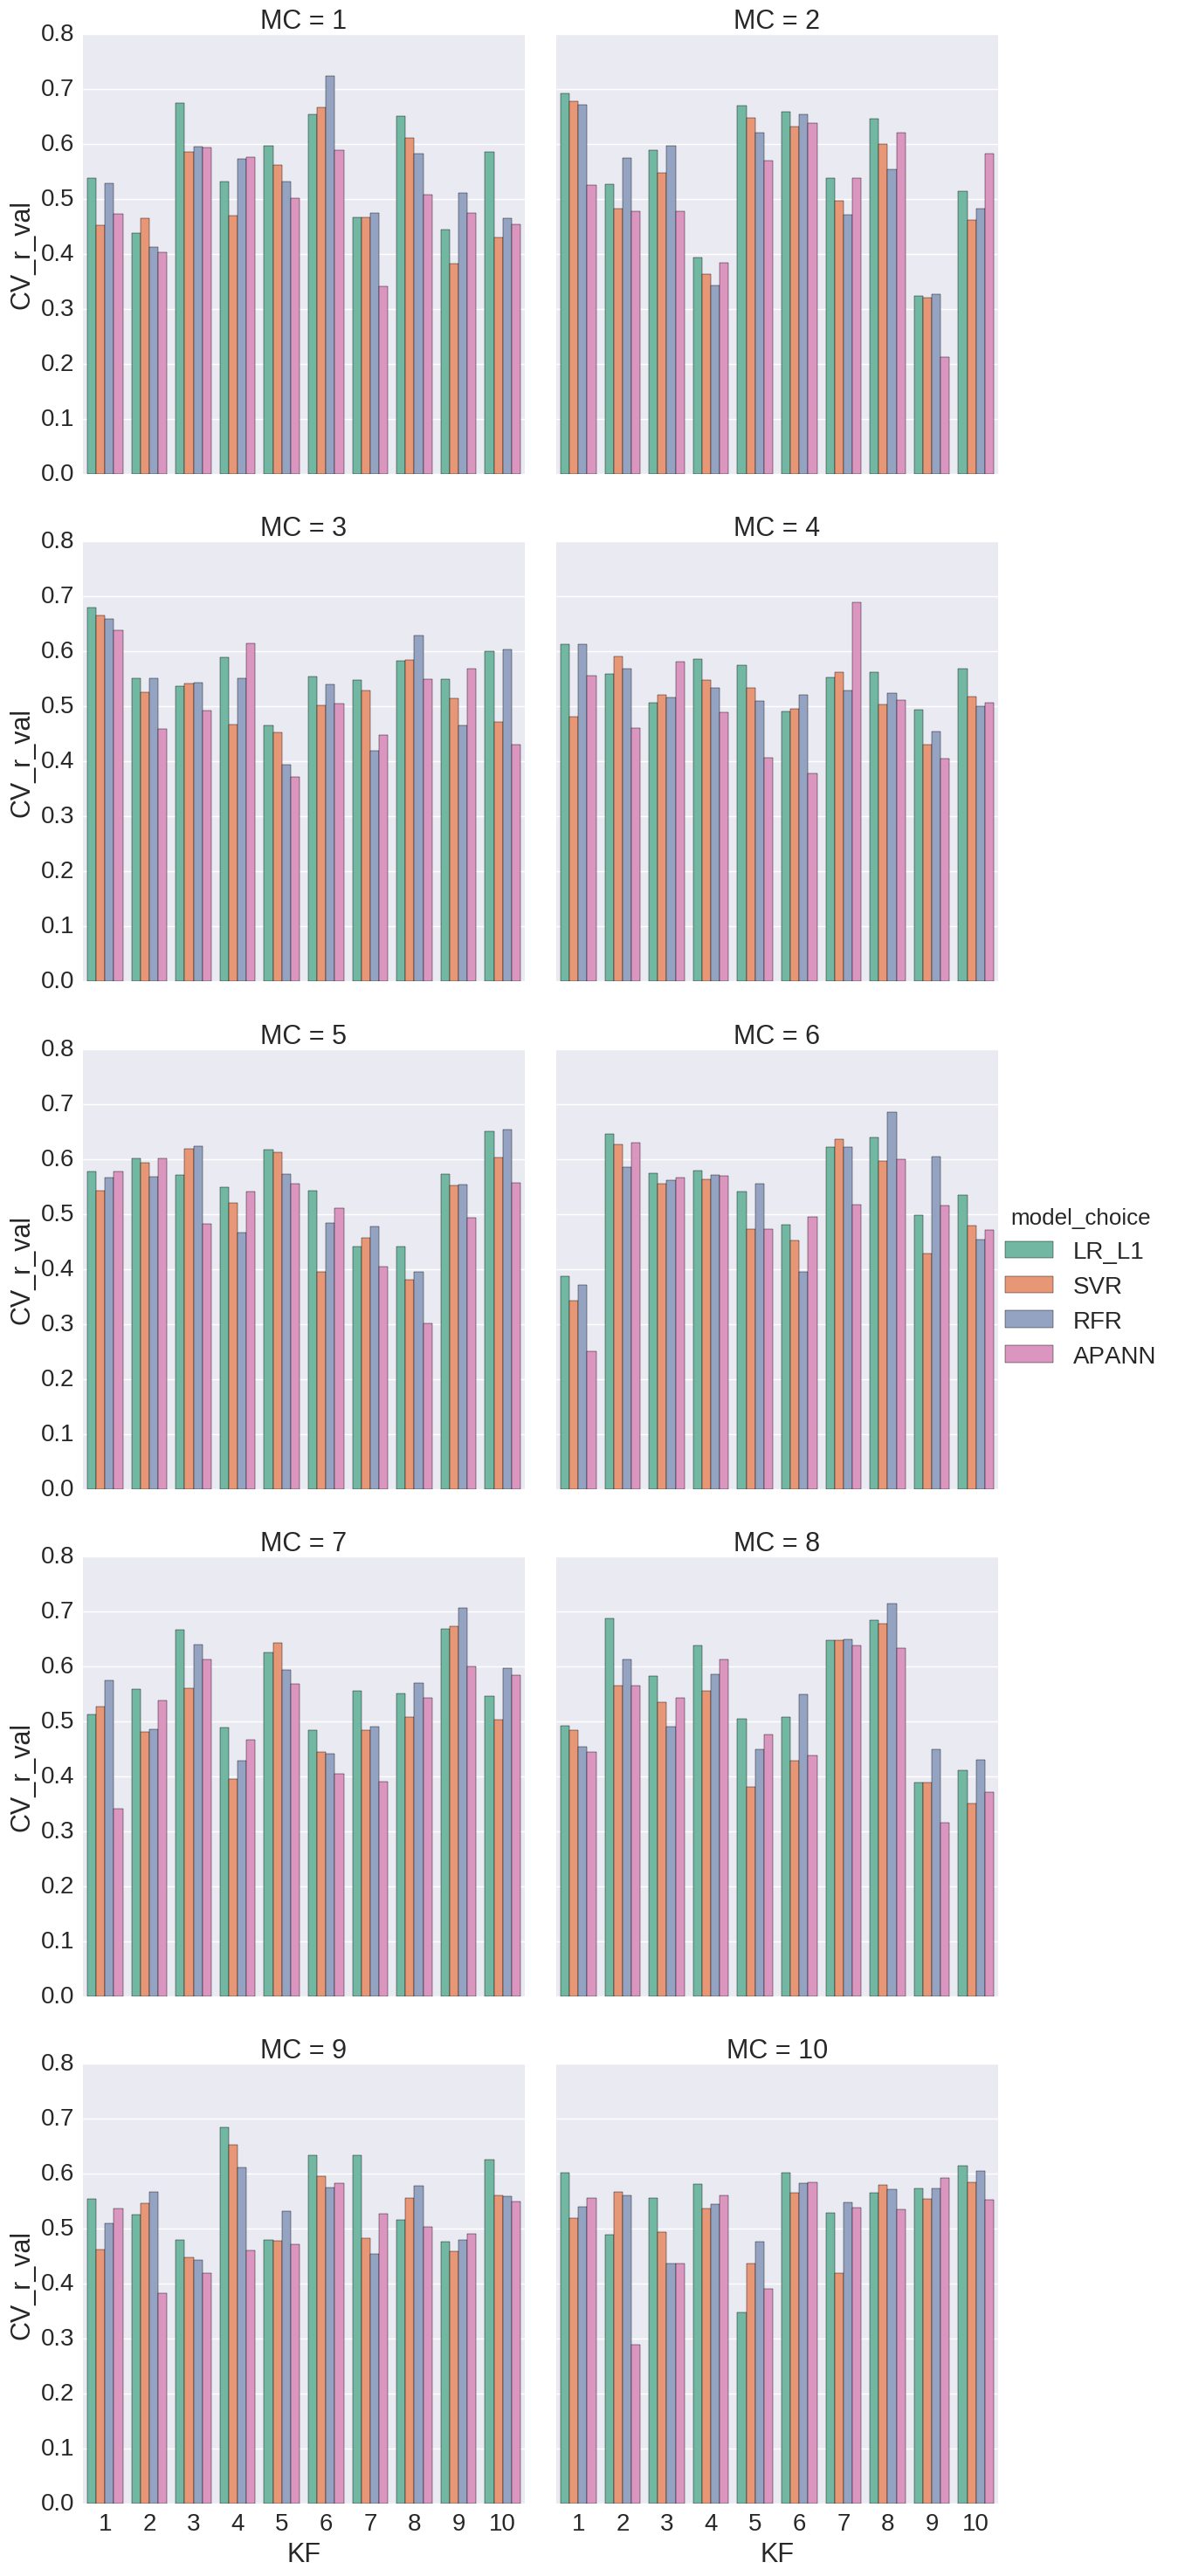

In [177]:
sns.set(style='whitegrid')
sns.set(font_scale=2)
save_figure = False
flatui = [ "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#9b59b6","#2ecc71"]
#palette = sns.color_palette(flatui)
palette = sns.color_palette('Set2')
g = sns.factorplot(x="KF", y="CV_r_val", hue="model_choice", col='MC', col_wrap=2,kind="bar",palette=palette, size=6, 
                   data=df_concat[(df_concat.modality=='CT') & (df_concat.cohort_CS == 'ADNI1_ADAS13')])
# g = sns.factorplot(x="modality", y="CV_r_val", hue="model_choice", col='cohort_CS',
#                    data=df_concat, kind="bar",palette=palette, size=6)
# statistical annotation
# x1, x2 = 2, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
# y, h, col = df_concat['CV_MSE'].max() + 2, 2, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

if save_figure:
    fig_name = 'test_1.eps'
    g.savefig(baseline_dir + fig_name, format='eps', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)

In [ ]:
# Compute single model from the most frequent hyper-params (for across dataset testing)

#test_clf = Lasso(alpha=0.05)    
#test_clf = SVR(kernel='rbf',C=1)
test_clf = RandomForestRegressor(n_estimators=200,min_samples_split=2,n_jobs=4)

save_CV_perf = False    
if save_CV_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + modality + '_' + st + '.pkl'
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                 'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    pickleIt(classifier_model_and_stats,save_model_filename)
    print 'saving results at: {}'.format(save_model_filename)


In [128]:
import itertools
model_choices = ['LR_L1','SVR','RFR','APANN']
modalities = ['CT','HC']
cohort_CS_list = ['ADNI1_ADAS13','ADNI1_MMSE']
use_atanh = True
idx=0
print 'use_atanh: {}'.format(use_atanh)
for cohort_cs in cohort_CS_list:    
    for modality in modalities:
        pairs = itertools.combinations(model_choices,2)
        for pair in pairs:            
            x = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
                          (df_concat.model_choice == pair[0])]['CV_r_val']
            y = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
                          (df_concat.model_choice == pair[1])]['CV_r_val']
            
            sign = computeSignficance(x,y,use_atanh)
            print cohort_cs, modality, pair, len(x), len(y), sign
        print ''
            

use_atanh: True
ADNI1_ADAS13 CT ('LR_L1', 'SVR') 100 100 ***
ADNI1_ADAS13 CT ('LR_L1', 'RFR') 100 100 ***
ADNI1_ADAS13 CT ('LR_L1', 'APANN') 100 100 ***
ADNI1_ADAS13 CT ('SVR', 'RFR') 100 100 ***
ADNI1_ADAS13 CT ('SVR', 'APANN') 100 100 ***
ADNI1_ADAS13 CT ('RFR', 'APANN') 100 100 ***

ADNI1_ADAS13 HC ('LR_L1', 'SVR') 100 100 **
ADNI1_ADAS13 HC ('LR_L1', 'RFR') 100 100 ***
ADNI1_ADAS13 HC ('LR_L1', 'APANN') 100 100 ***
ADNI1_ADAS13 HC ('SVR', 'RFR') 100 100 ***
ADNI1_ADAS13 HC ('SVR', 'APANN') 100 100 ***
ADNI1_ADAS13 HC ('RFR', 'APANN') 100 100 ***

ADNI1_MMSE CT ('LR_L1', 'SVR') 100 100 
ADNI1_MMSE CT ('LR_L1', 'RFR') 100 100 
ADNI1_MMSE CT ('LR_L1', 'APANN') 100 100 
ADNI1_MMSE CT ('SVR', 'RFR') 100 100 
ADNI1_MMSE CT ('SVR', 'APANN') 100 100 
ADNI1_MMSE CT ('RFR', 'APANN') 100 100 

ADNI1_MMSE HC ('LR_L1', 'SVR') 100 100 ***
ADNI1_MMSE HC ('LR_L1', 'RFR') 100 100 
ADNI1_MMSE HC ('LR_L1', 'APANN') 100 100 ***
ADNI1_MMSE HC ('SVR', 'RFR') 100 100 
ADNI1_MMSE HC ('SVR', 'APANN') 100 1

In [126]:
#Compute signficance of performance differences. If using correlations then use arctanh before the t-test
def computeSignficance(x,y,use_atanh):
    if use_atanh:
        #print 'Transforming correlation values using atan function'
        x = np.arctanh(x)
        y = np.arctanh(y)
        
    #compute t-tests
    t_val, p_val = stats.ttest_rel(x,y)    
    if p_val < 0.001:
        out = '***'
    elif p_val < 0.01:
        out = '**'
    elif p_val < 0.05:
        out = '*'
    else:
        out = ''
        
    return out

In [ ]:
# Plotting stuff...
boxplot_config_r = {}
boxplot_config_R2 = {}
boxplot_config_MSE = {}
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
Clinical_Scale = 'ADAS'
cohort = 'ADNI1'
multi_task = False #For ANN models
if Clinical_Scale == 'ADAS':
    if cohort == 'ADNI1':      
        baseline_models = {'LR_HC*':'Exp6_ADNI1_ADAS13_LR_L1_HC_2016-04-21-15-09-33.pkl',
                           'LR_CT*':'Exp6_ADNI1_ADAS13_LR_L1_CT_2016-04-21-15-13-04.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1_ADAS13_LR_L1_HC_CT_2016-04-21-15-04-00.pkl',
                           'SVR_HC*':'Exp6_ADNI1_ADAS13_SVR_HC_2016-04-21-15-14-29.pkl',
                           'SVR_CT*':'Exp6_ADNI1_ADAS13_SVR_CT_2016-04-21-15-17-53.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1_ADAS13_SVR_HC_CT_2016-04-21-15-28-22.pkl', 
                           'RFR_HC':'Exp6_ADNI1_ADAS13_RFR_HC_2016-04-21-15-40-32.pkl',
                           'RFR_CT':'Exp6_ADNI1_ADAS13_RFR_CT_2016-04-21-15-38-44.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1_ADAS13_RFR_HC_CT_2016-04-21-15-31-53.pkl'}
        
    if cohort == 'ADNI2':
        baseline_models = {'LR_HC*':'Exp6_ADNI2_ADAS13_LR_L1_HC_2016-04-21-15-07-08.pkl',
                           'LR_CT*':'Exp6_ADNI2_ADAS13_LR_L1_CT_2016-04-21-15-13-32.pkl',
                           'LR_HC_CT*':'Exp6_ADNI2_ADAS13_LR_L1_HC_CT_2016-04-21-15-04-35.pkl',
                           'SVR_HC*':'Exp6_ADNI2_ADAS13_SVR_HC_2016-04-21-15-14-13.pkl',
                           'SVR_CT*':'Exp6_ADNI2_ADAS13_SVR_CT_2016-04-21-15-20-53.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI2_ADAS13_SVR_HC_CT_2016-04-21-15-26-27.pkl', 
                           'RFR_HC':'Exp6_ADNI2_ADAS13_RFR_HC_2016-04-21-15-42-00.pkl',
                           'RFR_CT':'Exp6_ADNI2_ADAS13_RFR_CT_2016-04-21-15-36-31.pkl',
                           'RFR_HC_CT':'Exp6_ADNI2_ADAS13_RFR_HC_CT_2016-04-21-15-34-16.pkl'}
                
    if cohort == 'ADNI1and2':
        baseline_models = {'LR_HC*':'Exp6_concat_LR_L1_HC_2016-04-26-13-36-43.pkl',
                           'LR_CT*':'Exp6_concat_LR_L1_CT_2016-04-26-13-41-43.pkl',
                           'LR_HC_CT*':'Exp6_concat_LR_L1_HC_CT_2016-04-26-13-42-08.pkl',
                           'SVR_HC*':'Exp6_concat_SVR_HC_2016-04-26-13-54-38.pkl',
                           'SVR_CT*':'Exp6_concat_SVR_CT_2016-04-26-13-54-11.pkl',
                           'SVR_HC_CT*':'Exp6_concat_SVR_HC_CT_2016-04-26-13-48-03.pkl', 
                           'RFR_HC':'Exp6_concat_RFR_HC_2016-04-26-13-56-18.pkl',
                           'RFR_CT':'Exp6_concat_RFR_CT_2016-04-26-13-59-21.pkl',
                           'RFR_HC_CT':'Exp6_concat_RFR_HC_CT_2016-04-26-14-04-03.pkl'}
elif Clinical_Scale == 'MMSE':
    if cohort == 'ADNI1':    
        baseline_models = {'LR_HC*':'Exp6_ADNI1_MMSE_LR_L1_HC_2016-05-11-15-16-33.pkl',
                           'LR_CT*':'Exp6_ADNI1_MMSE_LR_L1_CT_2016-05-11-15-17-04.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1_MMSE_LR_L1_HC_CT_2016-05-11-15-17-21.pkl',
                           'SVR_HC*':'Exp6_ADNI1_MMSE_SVR_HC_2016-05-11-15-37-34.pkl',
                           'SVR_CT*':'Exp6_ADNI1_MMSE_SVR_CT_2016-05-11-15-37-08.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1_MMSE_SVR_HC_CT_2016-05-11-15-34-50.pkl', 
                           'RFR_HC':'Exp6_ADNI1_MMSE_RFR_HC_2016-05-11-15-38-55.pkl',
                           'RFR_CT':'Exp6_ADNI1_MMSE_RFR_CT_2016-05-11-15-42-19.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1_MMSE_RFR_HC_CT_2016-05-11-15-44-15.pkl'}
        
    if cohort == 'ADNI2':
        baseline_models = {'LR_HC*':'Exp6_ADNI2_MMSE_LR_L1_HC_2016-05-11-16-29-36.pkl',
                           'LR_CT*':'Exp6_ADNI2_MMSE_LR_L1_CT_2016-05-11-16-30-11.pkl',
                           'LR_HC_CT*':'Exp6_ADNI2_MMSE_LR_L1_HC_CT_2016-05-11-16-30-25.pkl',
                           'SVR_HC*':'Exp6_ADNI2_MMSE_SVR_HC_2016-05-11-16-30-48.pkl',
                           'SVR_CT*':'Exp6_ADNI2_MMSE_SVR_CT_2016-05-11-16-33-41.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI2_MMSE_SVR_HC_CT_2016-05-11-16-52-01.pkl', 
                           'RFR_HC':'Exp6_ADNI2_MMSE_RFR_HC_2016-05-11-16-54-51.pkl',
                           'RFR_CT':'Exp6_ADNI2_MMSE_RFR_CT_2016-05-11-16-59-24.pkl',
                           'RFR_HC_CT':'Exp6_ADNI2_MMSE_RFR_HC_CT_2016-05-11-18-29-58.pkl'}
                
    if cohort == 'ADNI1and2':
        baseline_models = {'LR_HC*':'Exp6_ADNI1and2_MMSE_LR_L1_HC_2016-05-13-13-17-45.pkl',
                           'LR_CT*':'Exp6_ADNI1and2_MMSE_LR_L1_CT_2016-05-13-13-18-17.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1and2_MMSE_LR_L1_HC_CT_2016-05-13-13-18-35.pkl',
                           'SVR_HC*':'Exp6_ADNI1and2_MMSE_SVR_HC_2016-05-13-13-19-11.pkl',
                           'SVR_CT*':'Exp6_ADNI1and2_MMSE_SVR_CT_2016-05-13-13-28-56.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1and2_MMSE_SVR_HC_CT_2016-05-13-13-45-58.pkl', 
                           'RFR_HC':'Exp6_ADNI1and2_MMSE_RFR_HC_2016-05-13-13-47-54.pkl',
                           'RFR_CT':'Exp6_ADNI1and2_MMSE_RFR_CT_2016-05-13-13-50-40.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1and2_MMSE_RFR_HC_CT_2016-05-13-13-56-10.pkl'}
        
        
# Not plotted:
# 'LR_L1': 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
# 'LR_L1_infl':'LR_L1_ADAS13_inflated_train_parallel_2015-11-27-15-05-17.pkl'
r_means =  {}  
r_medians =  {}
r_sems =  {}
rmse_means =  {}
rmse_sems =  {}
predicted_CV_scores = {}
actual_CV_scores = {}
keys_used = []
for key,val in baseline_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data = pickle.load(pkl_file)
    pkl_file.close()            
    boxplot_config_r[key] = (zip(*saved_data['CV_r'])[0])
    boxplot_config_MSE[key] = (saved_data['CV_MSE'])
    print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(zip(*saved_data['CV_r'])[0]),
                                              np.median(zip(*saved_data['CV_r'])[0]),
                                              np.std(zip(*saved_data['CV_r'])[0]))
    r_means[key] = (np.mean(zip(*saved_data['CV_r'])[0]))
    r_medians[key] = (np.median(zip(*saved_data['CV_r'])[0]))
    r_sems[key] = (stats.sem(zip(*saved_data['CV_r'])[0]))        

    rmse_means[key] = (np.mean(np.sqrt(saved_data['CV_MSE'])))
    rmse_sems[key] = (stats.sem(np.sqrt(saved_data['CV_MSE'])))  
    if key in ['LR_HC_CT*','SVR_HC_CT*','RFR_HC_CT']:
        predicted_CV_scores[key] = (saved_data['predicted_CV_scores'])
        actual_CV_scores[key] = (saved_data['actual_CV_scores'])
        
# Since ANN model perfs are saved differently :-/
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
if Clinical_Scale == 'ADAS':
    if cohort == 'ADNI1':
        if not multi_task:
            ANN_models ={'CT':'Exp6_ADNI1_ADAS13_NN_CT_2016-07-26-19-27-19.pkl',
                         'HC':'Exp6_ADNI1_ADAS13_NN_HC_2016-07-28-16-18-29.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_NN_HC_CT_2016-07-30-14-15-34.pkl'}
        else:
            ANN_models ={'HC':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_2016-06-02-10-26-05.pkl', 
                         'CT':'Exp6_ADNI1_ADAS13_MMSE_NN_CT_2016-06-01-23-42-45.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_CT_2016-05-24-11-35-17.pkl'}

    elif cohort == 'ADNI2':
        if not multi_task:
            ANN_models ={'CT':'Exp7_ADNI2_ADAS13_NN_CT_2016-04-25-15-40-42.pkl',
                         'HC':'Exp7_ADNI2_ADAS13_NN_HC_2016-04-25-22-08-00.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-08-03-20-27-06.pkl'}
        else:
            ANN_models ={'HC':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_2016-06-02-15-02-47.pkl',
                         'CT':'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-18-19-36.pkl'}

    elif cohort == 'ADNI1and2':
        if not multi_task:
            ANN_models ={'CT':'Exp8_ADNI1and2_ADAS13_NN_CT_2016-04-26-13-22-48.pkl',
                         'HC':'Exp8_ADNI1and2_ADAS13_NN_HC_2016-04-26-16-53-38.pkl',
                         'HC_CT':'Exp8_ADNI1and2_ADAS13_NN_HC_CT_2016-05-08-12-06-36.pkl'}
        else:
            ANN_models ={'HC':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_2016-06-03-14-04-38.pkl',
                         'CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_CT_2016-06-02-23-24-00.pkl',
                         'HC_CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_CT_2016-05-21-11-24-21.pkl'}
        
    else:
        print "Wrong cohort"
        
elif Clinical_Scale == 'MMSE':    
    if cohort == 'ADNI1':    
        if not multi_task:
            ANN_models ={'HC':'Exp6_ADNI1_MMSE_NN_HC_2016-05-10-23-14-55.pkl',
                         'CT':'Exp6_ADNI1_MMSE_NN_CT_2016-05-10-21-28-16.pkl',
                         'HC_CT':'Exp6_ADNI1_MMSE_NN_HC_CT_2016-05-11-10-21-35.pkl'}
        else:
            ANN_models ={'HC':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_2016-06-02-10-26-05.pkl', 
                         'CT':'Exp6_ADNI1_ADAS13_MMSE_NN_CT_2016-06-01-23-42-45.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_CT_2016-05-24-11-35-17.pkl'}

    elif cohort == 'ADNI2':
        if not multi_task:
            ANN_models ={'CT':'Exp11_ADNI2_MMSE_NN_CT_2016-05-09-16-07-42.pkl',
                         'HC':'Exp11_ADNI2_MMSE_NN_HC_2016-05-09-18-20-08.pkl',
                         'HC_CT':'Exp11_ADNI2_MMSE_NN_HC_CT_2016-05-14-23-15-06.pkl'}
        else:
            ANN_models ={'HC':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_2016-06-02-15-02-47.pkl',
                         'CT':'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-18-19-36.pkl'}

    elif cohort == 'ADNI1and2':
        if not multi_task:
            ANN_models ={'CT':'Exp13_ADNI1and2_MMSE_NN_CT_2016-05-13-19-59-43.pkl',
                         'HC':'Exp13_ADNI1and2_MMSE_NN_HC_2016-05-12-22-59-44.pkl',
                         'HC_CT':'Exp13_ADNI1and2_MMSE_NN_HC_CT_2016-05-16-10-49-37.pkl'}        
        else:
            ANN_models ={'HC':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_2016-06-03-14-04-38.pkl',
                         'CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_CT_2016-06-02-23-24-00.pkl',
                         'HC_CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_CT_2016-05-21-11-24-21.pkl'}
    else:
        print "Wrong cohort"

        
for key,val in ANN_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data_raw = pickle.load(pkl_file)
    if multi_task:
        saved_data = saved_data_raw['opt_{}'.format(Clinical_Scale)]        
        boxplot_config_r['ANN_'+key] = tuple(saved_data['CV_r'].values())
        boxplot_config_MSE['ANN_'+key] = tuple(saved_data['CV_MSE'].values())
        pkl_file.close()
        print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(saved_data['CV_r'].values()),
                                                  np.median(saved_data['CV_r'].values()),
                                                  np.std(saved_data['CV_r'].values()))
        r_means['ANN_'+key] = (np.mean(saved_data['CV_r'].values()))
        r_sems['ANN_'+key] = (stats.sem(saved_data['CV_r'].values()))

        rmse_means['ANN_'+key] = (np.mean(np.sqrt(saved_data['CV_MSE'].values())))
        rmse_sems['ANN_'+key] = (stats.sem(np.sqrt(saved_data['CV_MSE'].values())))
        if key == 'HC_CT':
            predicted_CV_scores['ANN_' + key] = (saved_data['predicted_CV_scores'].values())
            actual_CV_scores['ANN_' + key] = (saved_data['actual_CV_scores'].values())
            
    else:
        saved_data = saved_data_raw
        
        boxplot_config_r['ANN_'+key] = (saved_data['CV_r'])
        boxplot_config_MSE['ANN_'+key] = (saved_data['CV_MSE'])
        pkl_file.close()
        print 'key: {}, file: {}, mean: {}, median: {}, std: {}'.format(key,pkl_file,np.mean(saved_data['CV_r']),
                                                  np.median(saved_data['CV_r']),
                                                  np.std(saved_data['CV_r']))
        r_means['ANN_'+key] = (np.mean(saved_data['CV_r']))
        r_sems['ANN_'+key] = (stats.sem(saved_data['CV_r']))

        rmse_means['ANN_'+key] = (np.mean(np.sqrt(saved_data['CV_MSE'])))
        rmse_sems['ANN_'+key] = (stats.sem(np.sqrt(saved_data['CV_MSE'])))
        if key == 'HC_CT':
            predicted_CV_scores['ANN_' + key] = (saved_data['predicted_CV_scores'])
            actual_CV_scores['ANN_' + key] = (saved_data['actual_CV_scores'])            

In [ ]:
#plot foldwise results
plt.rcParams['figure.figsize'] = (20, 20)
fids = np.arange(1,11,1)
for key in ['ANN_CT','ANN_HC','ANN_HC_CT','LR_CT*','SVR_HC_CT*','RFR_HC_CT']: #boxplot_config_r.keys():
    if key in ['ANN_CT','ANN_HC','ANN_HC_CT']:
        custom_marker = 'd'    
        print 'modality: {}, perf: {}'.format(key, boxplot_config_r[key])
    else:
        custom_marker = 'o'        
    
    plt.subplot(2,1,1)
    plt.plot(fids,boxplot_config_r[key],linestyle='None',marker=custom_marker,markersize=15,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)    
    plt.xlim(0,11)
    plt.title('{}_{}'.format(cohort, Clinical_Scale))
    

    plt.subplot(2,1,2)
    plt.plot(fids,boxplot_config_MSE[key],linestyle='None',marker=custom_marker,markersize=15,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)
    plt.xlim(0,11)
    


In [ ]:
# Boxplots for CV statistics (r, mse, R2)
from sklearn.metrics import mean_squared_error as mse

stat_measure_list = [boxplot_config_r,boxplot_config_MSE] #boxplot_config_MSE
stat_measure_names = ['Pearson r', 'RMSE'] #'MSE'
from matplotlib.artist import setp
font_tiny = 20
font_small = 25
font_med = 30
font_large = 40
plt.rcParams['figure.figsize'] = (30, 40)

plot_score_diff = False #see trend of error w.r.t. actual scores
#plt.xkcd()

# custom_cols = ['LR_HC*','LR_CT*','LR_HC_CT*','SVR_HC*','SVR_CT*','SVR_HC_CT*','RFR_HC','RFR_CT','RFR_HC_CT',
#                'ANN_HC','ANN_CT','ANN_HC_CT']
custom_cols = ['LR_HC*','LR_CT*','LR_HC_CT*','SVR_HC*','SVR_CT*','SVR_HC_CT*','RFR_HC','RFR_CT','RFR_HC_CT'
               ,'ANN_HC','ANN_CT','ANN_HC_CT']

grp_idx = 3
boxplot = False
errorbarplot = True
scatterplot = True

my_colors = ['steelblue', 'olivedrab', 'cadetblue', 'salmon']
#plt.figure()
ax1 = plt.subplot2grid((6,2), (0,0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((6,2), (2,0), colspan=2,rowspan=2)
ax3 = plt.subplot2grid((6,2), (4,0))
ax4 = plt.subplot2grid((6,2), (4,1))
ax5 = plt.subplot2grid((6,2), (5,0))
ax6 = plt.subplot2grid((6,2), (5,1))

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]

if errorbarplot:
    custom_r_means = []    
    custom_r_sems = []    
    custom_rmse_means = []
    custom_rmse_sems = []
    for c, col in enumerate(custom_cols):
        custom_r_means.append(r_means[col])        
        custom_r_sems.append(r_sems[col])
        custom_rmse_means.append(rmse_means[col])        
        custom_rmse_sems.append(rmse_sems[col])
        
    if grp_idx == 3:
        x_r = np.array([0,1,2,4,5,6,8,9,10,12,13,14])  # padding to better appearance 
    else:
        x_r = np.array([0,1,2,3])  # padding to better appearance 
    
    x_mse = x_r 
    #plt.bar(x, np.array(custom_r_means), yerr=np.array(custom_r_sems))
    width = 0.25                    # bar width

    #fig, ax = plt.subplots()
    plot_corr = True
    if plot_corr: 

        rects1 = ax1.bar(x_r[:grp_idx], custom_r_means[:grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[0],        # bar colour
                        yerr=custom_r_sems[:grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},       # error-bar width
                        label = 'Linear Regression')

        rects2 = ax1.bar(x_r[grp_idx:2*grp_idx], custom_r_means[grp_idx:2*grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[1],        # bar colour
                        yerr=custom_r_sems[grp_idx:2*grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                        label = 'Support Vector Regression')

        rects3 = ax1.bar(x_r[2*grp_idx:3*grp_idx], custom_r_means[2*grp_idx:3*grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[2],        # bar colour
                        yerr=custom_r_sems[2*grp_idx:3*grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                         label = 'Random Forest')

        rects4 = ax1.bar(x_r[3*grp_idx:], custom_r_means[3*grp_idx:],                  # data
                        width,                          # bar width
                        color=my_colors[3],        # bar colour
                        yerr=custom_r_sems[3*grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                        label = 'Artificial Neural Network')
        autolabel(rects1,ax1)
        autolabel(rects2,ax1)
        autolabel(rects3,ax1)
        autolabel(rects4,ax1)
        #Plot annotations 
        ax1.set_ylabel('Correlation',fontsize=font_large)
        ax1.set_xlim(-0.5,max(x_r)+1)
        ax1.set_ylim(0,1)
        ax1.set_xticks(x_r + .1)
        ax1.set_xticklabels(custom_cols,rotation=10)
        ax1.tick_params(labelsize=font_small)
        #ax1.set_yticks(fontsize=font_med)
        ax1.set_title('{}_{}'.format(cohort, Clinical_Scale),fontsize=font_med)
        ax1.legend(fontsize=font_med, loc=2)
    
    plot_mse = True
    if plot_mse: 
        rects5 = ax2.bar(x_mse[:grp_idx], custom_rmse_means[:grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[0],        # bar colour
                        yerr=custom_rmse_sems[:grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects6 = ax2.bar(x_mse[grp_idx:2*grp_idx], custom_rmse_means[grp_idx:2*grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[1],        # bar colour
                        yerr=custom_rmse_sems[grp_idx:2*grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects7 = ax2.bar(x_mse[2*grp_idx:3*grp_idx], custom_rmse_means[2*grp_idx:3*grp_idx],                  # data
                        width,                          # bar width
                        color=my_colors[2],        # bar colour
                        yerr=custom_rmse_sems[2*grp_idx:3*grp_idx],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects8 = ax2.bar(x_mse[3*grp_idx:], custom_rmse_means[3*grp_idx:],                  # data
                        width,                          # bar width
                        color=my_colors[3],        # bar colour
                        yerr=custom_rmse_sems[3*grp_idx:],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})
        autolabel(rects5,ax2)
        autolabel(rects6,ax2)
        autolabel(rects7,ax2)
        autolabel(rects8,ax2)

        #Plot annotations 
        ax2.set_ylabel('RMSE',fontsize=font_large)
        ax2.set_xlim(-0.5,max(x_r)+1)
        if Clinical_Scale == 'ADAS':
            ax2.set_ylim(0,12)
        elif Clinical_Scale == 'MMSE':
            ax2.set_ylim(0,4)
        else:
            print 'unknown clinical scale'
        
        ax2.set_xticks(x_r + 0.1)
        ax2.set_xticklabels(custom_cols,rotation=10)
        ax2.tick_params(labelsize=font_small)
        #ax1.set_yticks(fontsize=font_med)
        ax2.legend(fontsize=font_med, loc=2)
    
if scatterplot:
    #plt.figure()
    #fid = 4
    for k, key in enumerate(['LR_HC_CT*','SVR_HC_CT*', 'RFR_HC_CT', 'ANN_HC_CT']):
        x = np.squeeze(np.hstack(actual_CV_scores[key]))
        y = np.squeeze(np.hstack(predicted_CV_scores[key]))
        
        if plot_score_diff:
            y = (y-x)
            ax_list[k+ax_offset].set_ylabel('(Predicted - Actual) Score',fontsize=font_small)            
            label_str = 'Clinical Scale: {}'.format(Clinical_Scale) + '\n' + 'cohort: {}'.format(cohort)                   
            
        fit = np.polyfit(x,y,1)
        fit_fn = np.poly1d(fit) 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        rmse_value = np.sqrt(mse(x,y))
        if p_value < 0.0001:
            p_value_sig = '<0.0001'
        else:
            p_value_sig = str(p_value)
            
        #Plot annotations  
        if not plot_score_diff:
            label_str = 'model: {}'.format(key) + '\n' + 'r: {:04.2f}'.format(r_value) + '\n' + 'rmse: {:04.2f}'.format(rmse_value) 
            if Clinical_Scale == 'ADAS':                
                ax_list[k+ax_offset].set_ylim(0,40)
            elif Clinical_Scale == 'MMSE':                
                ax_list[k+ax_offset].set_ylim(20,35)
            else:
                print 'unknown clinical scale'
            ax_list[k+ax_offset].set_ylabel('Predicted Score',fontsize=font_small)            
            
        # fit_fn is now a function which takes in x and returns an estimate for y                
        ax_list[k+ax_offset].plot(x, fit_fn(x),linewidth=3, c=my_colors[k], label=label_str)
        #plt.title(model_choice,fontsize=font_large)                        
        ax_offset = 2
        #plt.subplot(2,2,k+1)        
        ax_list[k+ax_offset].scatter(x, y, c=my_colors[k], s=40)                
        ax_list[k+ax_offset].set_xlabel('Actual Score',fontsize=font_small)        
        ax_list[k+ax_offset].legend(fontsize=font_tiny,loc=2)
        ax_list[k+ax_offset].tick_params(labelsize=font_med)

#Save figure
save_fig = True
if save_fig:
    exp_name = 'Exp6'
    save_name = '{}{}_{}_{}_PerfPlots.tif'.format(boxplots_dir, exp_name, cohort, Clinical_Scale)
    print 'Save image path: ' + save_name
    box_fig = plt.gcf()
    box_fig.savefig(save_name,format='TIFF', dpi=1000)

In [12]:
# Some Defs
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    RMSE_train = np.sqrt(mse(clf.predict(train_X),train_y))
    RMSE_valid = np.sqrt(mse(clf.predict(valid_X),valid_y))
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'RMSE_train':RMSE_train, 'RMSE_valid':RMSE_valid,
            'hp_dict':hp_dict, 'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.1*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 35)


In [ ]:
CS_vals = sub_CS_dict_clean.values()
plt.hist(CS_vals)

In [ ]:
cohort = 'ADNI2'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_Exp5_{}_ADAS13.pkl'.format(cohort)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
kf = exp_setup['kf']
adni2_sub_list = exp_setup['common_subs']

In [ ]:
common_keys = list(set(adni1_sub_list) & set(adni2_sub_list))
print len(adni1_sub_list), len(adni2_sub_list)
print common_keys
                

In [ ]:
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
adni1_RFR_file = 'Exp4_ADNI1_ADAS13_RFR_HC_CT_2016-02-29-15-24-23.pkl'
adni2_RFR_file = 'Exp5_ADNI2_ADAS13_RFR_HC_CT_2016-04-04-16-18-06.pkl'
pkl_file = open(boxplots_dir + adni1_RFR_file, 'rb')
saved_data = pickle.load(pkl_file)
pkl_file.close()            

adni1_act_scores = np.hstack(saved_data['actual_CV_scores'])
adni1_prd_scores = np.hstack(saved_data['predicted_CV_scores'])

pkl_file = open(boxplots_dir + adni2_RFR_file, 'rb')
saved_data = pickle.load(pkl_file)
pkl_file.close()            

adni2_act_scores = np.hstack(saved_data['actual_CV_scores'])
adni2_prd_scores = np.hstack(saved_data['predicted_CV_scores'])

# print np.hstack(adni1_act_scores)
plt.subplot(2,1,1)
plt.scatter(adni1_act_scores,adni1_prd_scores,c='olivedrab')
plt.title('ADNI1 Perf')
plt.xlabel('Actual ADAS scores')
plt.ylabel('Predicted ADAS scores')
plt.subplot(2,1,2)
plt.scatter(adni2_act_scores,adni2_prd_scores,c='olivedrab')
plt.xlabel('Actual ADAS scores')
plt.ylabel('Predicted ADAS scores')
plt.title('ADNI2 Perf')

box_fig = plt.gcf()
box_fig.savefig('/projects/nikhil/ADNI_prediction/input_datasets/CS/adas_correlations.png', bbox_inches='tight')



In [ ]:
import itertools
node_sizes1 = {'L_ff1':50,'R_ff1':50,'L_ff2':50,'R_ff2':50,'ff1':100,'ff2':100,'ff3':20}
node_sizes2 = {'L_ff1':50,'R_ff1':50,'L_ff2':50,'R_ff2':50,'ff1':100,'ff2':100,'ff3':40}
dr1 = {'HC':0.25,'CT':0.25}
dr2 = {'HC':0.5,'CT':0.5}

list1 = ['node_sizes1','node_sizes2']
list2 = ['dr1','dr2']

s=[list1,list2 ]
hype_combs = list(itertools.product(*s))
hype_configs = {}
for c, comb in enumerate(hype_combs):
    hype_configs['hyp{}'.format(c)] = {'node_sizes':comb}
    
    hype_configs = {'hyp1':{'node_sizes':{'L_ff1':50,'R_ff1':50,'L_ff2':50,'R_ff2':50,'ff1':100,'ff2':100,'ff3':20},
                       'dr':{'HC':0.25,'CT':0.25}},
                'hyp2':{'node_sizes':{'L_ff1':50,'R_ff1':50,'L_ff2':50,'R_ff2':50,'ff1':100,'ff2':100,'ff3':40},
                       'dr':{'HC':0.5,'CT':0.5}}
               }

In [ ]:
plt.subplot(2,1,1)
plt.title('HC_L total volume')
plt.hist(X[y_dx_int==0,0],bins=100,alpha=alpha,label='AD: {}'.format(np.mean(X[y_dx_int==0,0])))
plt.hist(X[y_dx_int==1,0],bins=100,alpha=alpha,label='CN: {}'.format(np.mean(X[y_dx_int==1,0])))
plt.hist(X[y_dx_int==2,0],bins=100,alpha=alpha,label='MCI: {}'.format(np.mean(X[y_dx_int==2,0])))
plt.legend()
plt.subplot(2,1,2)
plt.title('HC_R total volume')
plt.hist(X[y_dx_int==0,1],bins=100,alpha=alpha,label='AD: {}'.format(np.mean(X[y_dx_int==0,1])))
plt.hist(X[y_dx_int==1,1],bins=100,alpha=alpha,label='CN: {}'.format(np.mean(X[y_dx_int==1,1])))
plt.hist(X[y_dx_int==2,1],bins=100,alpha=alpha,label='MCI: {}'.format(np.mean(X[y_dx_int==2,1])))
plt.legend()

In [ ]:
import seaborn as sns

In [ ]:
# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');

In [ ]:
x = np.ones(10)
y = 2*x
print x
sns.jointplot(x,y)

In [87]:
16*24

384

In [ ]:
        ADAS        MMSE
ADNI1   15793       15793  (Exp6)
ADNI2   17358/17240 17240  (Exp7/Exp11)  
ADNI1_2 33152       33035  (Exp8/Exp13)

In [ ]:
print x.shape, y.shape

In [ ]:
HC_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_HC_2016-06-02-15-02-47.pkl'
CT_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl'
pkl_file = open(boxplots_dir + CT_file, 'rb')
saved_data_raw = pickle.load(pkl_file)

In [ ]:
saved_data_raw['opt_hype']

In [ ]:
CT_file = 'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl'
pkl_file = open(boxplots_dir + CT_file, 'rb')
saved_data = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
saved_data['opt_hype']

In [132]:
import tables as tb
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

In [ ]:
import h5py as h5
import tables as tb
import numpy as np
fid = 4
subset = 'valid'
hdf_file = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp11_ADNI2_ADAS13_NN_{}.h5'.format(subset)
dataset = 'Fold_{}_{}_dx'.format(fid,subset)

save_to_file = False
dummy_vars = np.array(['AD', 'LMCI', 'EMCI', 'SMC', 'CN'])
dummy_var_array = create_dummy_vars(hdf_file, dataset, dummy_vars, save_to_file)

print 'output_vector'
print dummy_var_array
print np.sum(dummy_var_array==0)/float(len(dummy_var_array)), np.sum(dummy_var_array==1)/float(len(dummy_var_array)), np.sum(dummy_var_array==2)/float(len(dummy_var_array))

In [ ]:
def create_dummy_vars(input_file, dataset, dummy_vars,save_to_file):        
    #takes a categorical output variable and changes to binary vectorized form
    #dummy_vars lists all the categories 
    dummy_var_match_list = []                    
    categorical_data = load_data(input_file, dataset, 'no_preproc')         
    for cat_data_item in categorical_data:        
        match_list = dummy_vars == cat_data_item                
        if np.sum(match_list) == 1:
            match_list = np.argmax(match_list)
            dummy_var_match_list.append(match_list)        
        else:
            print 'no match found for {}'.format(cat_data_item)
            
    
    output_vector = np.array(dummy_var_match_list)  
    #print output_vector
    #collapse LMCI-->EMCI and smcs-->CN
    output_vector[output_vector==2] = 1
    output_vector[output_vector==3] = 2
    output_vector[output_vector==4] = 2
    
    if save_to_file:
        print 'Adding vectorized dataset to: {}'.format(input_file)
        
#         hdf_data = h5.File(input_file, mode='a')            
#         hdf_data.create_dataset(dataset + '_vectorized', data=output_vector)            
#         hdf_data.close()   
        
        # use table to save data
        FILTERS = tb.Filters(complevel=5,complib='zlib')    
        fileh = tb.open_file(input_file, mode='a', filters=FILTERS)        
        data  = fileh.create_array(fileh.root, dataset + '_cat3', output_vector)
        fileh.close()
        
    return output_vector
        

In [ ]:
hdf_data = h5.File(hdf_file) 
hdf_data.close() 
FILTERS = tb.Filters(complevel=5,complib='zlib')    
fileh = tb.open_file(hdf_file, mode='r', filters=FILTERS)
fileh.close()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

fid = 4
cm = plt.get_cmap('viridis') 
adas = load_data(hdf_file, 'Fold_{}_{}_y'.format(fid,subset), 'no_preproc')
mmse = load_data(hdf_file, 'Fold_{}_y3'.format(fid), 'no_preproc')

plt.scatter(adas,mmse,c=dummy_var_array,s=50,cmap=cm)
plt.colorbar()


In [82]:
4*80000/5000

64

In [175]:
import h5py
in_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/caffe_input/'
out_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_1/'
subset = 'train'

out_file = out_dir + 'fold{}/inner_train/Exp6_MC.h5'

comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
for fid in np.arange(1,11,1):
    #inner train and test
    in_file = in_dir + 'CV_Exp6_ADNI1_NN_OuterFold_MC_1_fold{}_{}_InnerFold_1.h5'.format(fid,subset)
    aal = load_data(in_file,'Fold_{}_CT_AAL_dyn'.format(fid), 'no_preproc')
    
    #outer test
#     in_file = in_dir + 'CV_Exp6_ADNI1_ADAS13_NN_{}_MC_1.h5'.format(subset)
#     aal = load_data(in_file,'Fold_{}_{}_AAL'.format(fid,subset), 'no_preproc')
    
    
    with h5py.File(out_file.format(fid), 'a') as f:                 
        f.create_dataset('X_CT_AAL_dyn', data=aal, **comp_kwargs)

In [118]:
df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
                          (df_concat.model_choice == 'APANN')]

,CV_RMSE,model_choice,KF,MC,CV_R2,CV_r,CV_MSE,modality,CV_r_val,CV_r_pval,cohort_CS
0,2.369300,APANN,1,1,0.0,0.454315,5.613583,CT,0.454315,0.0,ADNI1_MMSE
1,2.613528,APANN,2,1,0.0,0.391451,6.830530,CT,0.391451,0.0,ADNI1_MMSE
2,2.399761,APANN,3,1,0.0,0.387592,5.758855,CT,0.387592,0.0,ADNI1_MMSE
3,2.362185,APANN,4,1,0.0,0.506991,5.579920,CT,0.506991,0.0,ADNI1_MMSE
4,2.460248,APANN,5,1,0.0,0.546696,6.052819,CT,0.546696,0.0,ADNI1_MMSE
5,2.193912,APANN,6,1,0.0,0.612299,4.813250,CT,0.612299,0.0,ADNI1_MMSE
6,2.622675,APANN,7,1,0.0,0.47063,6.878425,CT,0.470630,0.0,ADNI1_MMSE
7,2.059306,APANN,8,1,0.0,0.651623,4.240740,CT,0.651623,0.0,ADNI1_MMSE
8,2.187367,APANN,9,1,0.0,0.43842,4.784576,CT,0.438420,0.0,ADNI1_MMSE
9,2.341125,APANN,10,1,0.0,0.524339,5.480864,CT,0.524339,0.0,ADNI1_MMSE
